This example shows how to use `rrlpy` to fit a Voigt line profile to one RRL and then use the best fit line centroid to fit a higher frequency RRL.

In this example we will use the H\\(180\alpha\\) and H\\(260\alpha\\) lines. We will fit the H\\(260\alpha\\) using a Voigt profile, and then use the best fit velocity centroid to fit the H\\(180\alpha\\) line.

In [1]:
# Load modules.
import pickle
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple
from scipy.optimize import minimize
from IPython.display import display, Math

import emcee

from astropy import units as u
from astropy import constants as ac
from chainconsumer import ChainConsumer

from rrlpy.rrl import RRLs, voigt
from rrlpy.synth import layers
from rrlpy.departure import BnBeta
from rrlpy.continuum import PowerLaw

First, we start by creating the H\\(180\alpha\\) and H\\(260\alpha\\) spectra. If you're working with real data, you can skip this step and continue [here](#real-data-start)
.

In [2]:
# Set up departure coefficients.
# You'll have to set the path and the filenames.
path = "/home/scratch/psalas/projects/GDIGS-Low/analysis/simulations/layered_emission/"
bn = np.load(f'{path}/bn_hrrl.npy')
beta = np.load(f'{path}/beta_hrrl.npy')
bn_head = pickle.load(open(f'{path}/bn_hrrl_head.p', "rb" ))
bnbeta = BnBeta(bn[0,0,:], bn[:,-1,:], bn_head["Te_v"]*u.K, bn_head["ne_v"]*u.cm**-3, None, beta=beta[:,:,0])

# Interpolate the departure coefficients.
# You can ignore the warning.
bnbeta_i = bnbeta.interpolate()

# Set up lines.
rrls = RRLs(np.array([180, 260]), # Principal quantum numbers.
            ["H", "H"], # Element.
            ["alpha"]*2, # Transition.
            np.array([1, 1]), # Net charge, Z.
            )

# Set up radiation fields.
background = PowerLaw(0.14*33.*u.K, 1*u.GHz, -2.2)
medium = PowerLaw(0.*u.K, 1*u.GHz, -2.6)

# X-axis for the spectra.
x_axis = np.arange(-300, 300, 1) * u.km/u.s

# Define a gas layer.
layer = layers.Layer(3*u.cm**-3, 7000*u.K, 220*u.pc, 1*u.km/u.s,
                     bnbeta_i, rrls, background, medium,
                     x_axis=x_axis, velocity=100*u.km/u.s)

# Compute the line emission from the layer.
# We will use this as our "observed" data, or mock data.
layer.compute()

# Add noise so the S/N is ~10.
for i,n in enumerate(rrls.qn):
    peak = layer.tl_x[i].max().to("K").value
    rms = 0.1*peak
    layer.tl_x[i] += np.random.normal(0, rms, size=layer.tl_x[i].shape) * u.K

/home/sandboxes/psalas/RRLpy/rrlpy/src/rrlpy/departure/bnbeta.py:87: UserWarning: Will use all n values.
  warnings.warn("Will use all n values.")


The above cell generated our spectra. Lets look at it.

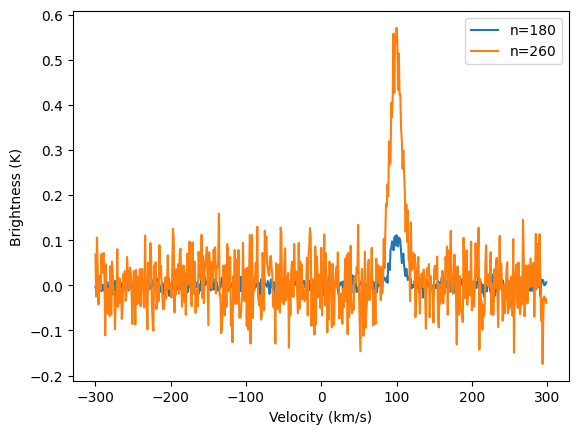

In [3]:
plt.figure()
for i,n in enumerate(rrls.qn):
    plt.plot(x_axis, layer.tl_x[i].to("K"), label=f"n={n}")
plt.legend()
plt.xlabel("Velocity (km/s)")
plt.ylabel("Brightness (K)");

If you are working with real data, this is where you'd start. 
<a name="real-data-start"></a>

In [4]:
spec_180 = layer.tl_x[0].to("K").value # H180alpha line
spec_260 = layer.tl_x[1].to("K").value # H260alpha line
velo = x_axis.to("km/s").value # Velocity axis, assume it is the same for both spectra.

We will fit the H\\(260\alpha\\) line and use its velocity centroid to fit the H\\(180\alpha\\) line.

We define a model and a log likelihood function. For the model we use a Voigt line profile, which is appropriate when the frequency dependent broadening terms are significant.

In [5]:
# Model function. This needs to be changed if using 
# a different line profile, or fitting multiple velocity 
# components.
def model(params, x_axis, v_cen=None):
    """
    Generates the RRL spectra given the current vector of parameters values.
    The central velocity, `v_cen`, can be given or a parameter to be fit.
    """

    if v_cen is not None:
        center = v_cen
        amplitude, sigma, gamma = unpack_params(params)
    else:
        amplitude, sigma, gamma, center = unpack_params(params)

    profile = voigt(x_axis, sigma, gamma, center, amplitude)
    
    return profile


def unpack_params(params):
    """
    Unpack parameters into amplitude, sigma, gamma, 
    and, if appropriate, center.
    """

    amplitude = params[0]
    sigma = params[1]
    gamma = params[2]
    pars = amplitude, sigma, gamma
    if len(params) == 4:
        center = params[3]
        pars += (center,)

    return pars


def log_likelihood(params, x, y, yerr, v_cen=None):
    """
    Log likelihood assuming Gaussian distribution.
    """
    ymod = model(params, x, v_cen=v_cen)

    return -0.5*np.sum( np.power((ymod - y)/yerr, 2.) )

Minimize the negative log likelihood to find the best fit parameters.

In [6]:
nll = lambda *args: -log_likelihood(*args)

# Setting up the starting parameter values.
# These are determined from a visual inspection 
# of the spectra.
# Amplitude, sigma, gamma and center.
pos = [5, 1, 10, 105]

soln = minimize(nll, pos, args=(velo, spec_260, 1.))
print(soln)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.9394639845646089
        x: [ 1.081e+01  9.470e+00  2.943e-01  9.959e+01]
      nit: 40
      jac: [ 8.270e-07 -1.490e-07 -7.078e-07  8.047e-07]
 hess_inv: [[ 1.491e+02 -1.565e+02  2.738e+02 -6.854e-01]
            [-1.565e+02  4.058e+02 -5.056e+02  2.418e+00]
            [ 2.738e+02 -5.056e+02  7.333e+02 -3.928e+00]
            [-6.854e-01  2.418e+00 -3.928e+00  2.949e+01]]
     nfev: 220
     njev: 44


Compare the best fit line profile with the actual data.

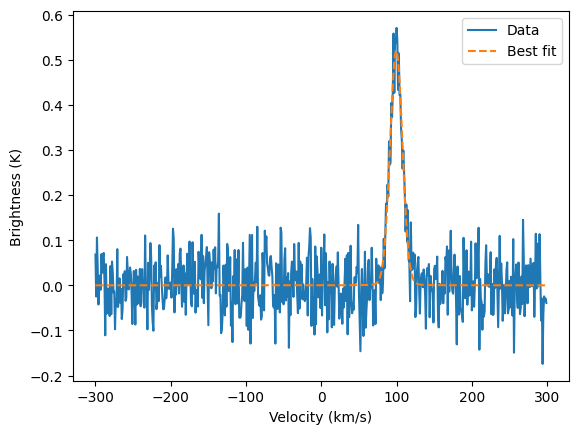

In [7]:
plt.figure()
plt.plot(velo, spec_260, label="Data")
plt.plot(velo, model(soln.x, velo), label="Best fit", ls="--")
plt.legend()
plt.xlabel("Velocity (km/s)")
plt.ylabel("Brightness (K)");

The best fit and the data are almost identical. No big surprise, since we are using noiseless data and the model used to fit and generate the data is the same.

Now, we will use the best fit line centroid to fit the higher frequency transition.

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.431325214957951
        x: [ 2.024e+00  8.989e+00 -2.230e-03]
      nit: 15
      jac: [ 3.994e-06 -4.232e-06 -5.841e-06]
 hess_inv: [[ 1.261e+00 -6.429e+00  1.124e+01]
            [-6.429e+00  8.085e+01 -1.034e+02]
            [ 1.124e+01 -1.034e+02  1.523e+02]]
     nfev: 72
     njev: 18


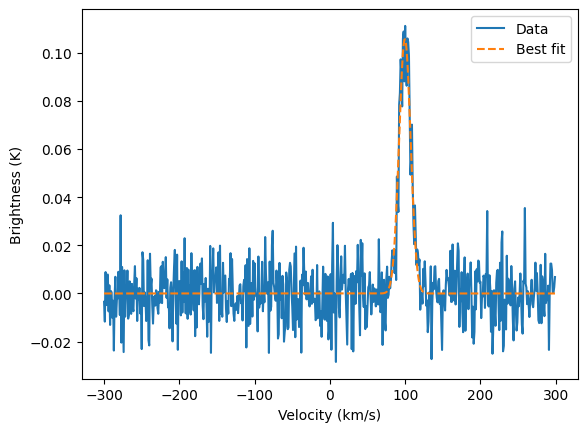

In [8]:
v_cen_260 = soln.x[-1] # Use the line centroid from the lower frequency fit.
pos = [soln.x[0]*0.17, soln.x[1], 1]
sol_180 = minimize(nll, pos, args=(velo, spec_180, 0.1, v_cen_260))
print(sol_180) # Notice that gamma is negative.

# Plot the solution and the data.
plt.figure()
plt.plot(velo, spec_180, label="Data")
plt.plot(velo, model(abs(sol_180.x), velo, v_cen=v_cen_260), label="Best fit", ls="--")
plt.legend()
plt.xlabel("Velocity (km/s)")
plt.ylabel("Brightness (K)");

Now that we have maximum likelihood parameters we can also estimate their uncertainties using MCMC. We will use `emcee` for running the MCMC. We will need to define a couple of functions for this: the log prior and the probability.

In [9]:
def log_prior(params):
    """
    Priors.
    """
    # Check the bounds of the parameters
    if len(params) == 4:
        amplitude, sigma, gamma, center = unpack_params(params)
    else:
        amplitude, sigma, gamma = unpack_params(params)
        center = 100
    
    lnp = 0
    if (amplitude < 0 or amplitude > 30) \
    or (sigma < 0 or sigma > 20) or (gamma < 0 or gamma > 5) \
    or (center > 150 or center < 50):
        return -np.inf
            
    return lnp


def log_prob(params, x, y, yerr, **kwargs):
    """
    Function for `emcee`.
    """

    # params = set_params(theta, params=params)
    lp = log_prior(params)

    return lp + log_likelihood(params, x, y, yerr, **kwargs)


# Parameter names.
pars = ["amplitude", "sigma", "gamma", "center"]

Use the maximum likelihood parameters to set the starting values for the walkers.

In [10]:
# Gamma may have a negative value, which is not physical, but 
# the Voigt profile does not care if the value is negative.
pos = abs(soln.x) + 1e-2 * np.random.randn(32, len(soln.x))
nwalkers, ndim = pos.shape

# Set up and start the MCMC.
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(velo, spec_260, 1.e-1)
)
sampler.run_mcmc(pos, 5000, progress=True);

 27%|████████████████████████████████████████████▉                                                                                                                         | 1353/5000 [00:12<00:34, 105.64it/s]/tmp/ipykernel_21038/1558839340.py:44: RuntimeWarning: overflow encountered in power
  return -0.5*np.sum( np.power((ymod - y)/yerr, 2.) )
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:46<00:00, 106.73it/s]


Inspect the posterior distributions for the Voigt profile parameters using different tools.

In [11]:
flat_sample = sampler.get_chain(discard=sampler.iteration // 2, flat=True)

for i,p in enumerate(pars):
    mcmc = np.percentile(flat_sample[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], p)
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

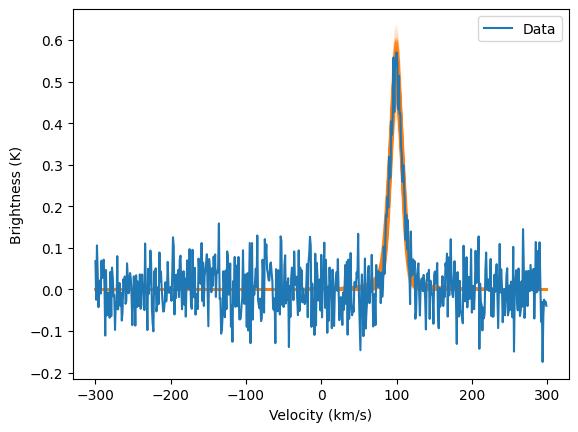

In [12]:
inds = np.random.randint(len(flat_sample), size=500)
for ind in inds:
    sample = flat_sample[ind]
    plt.plot(velo, model(sample, velo), "C1", alpha=0.1)
plt.plot(velo, spec_260, label="Data")
plt.legend()
plt.xlabel("Velocity (km/s)")
plt.ylabel("Brightness (K)");

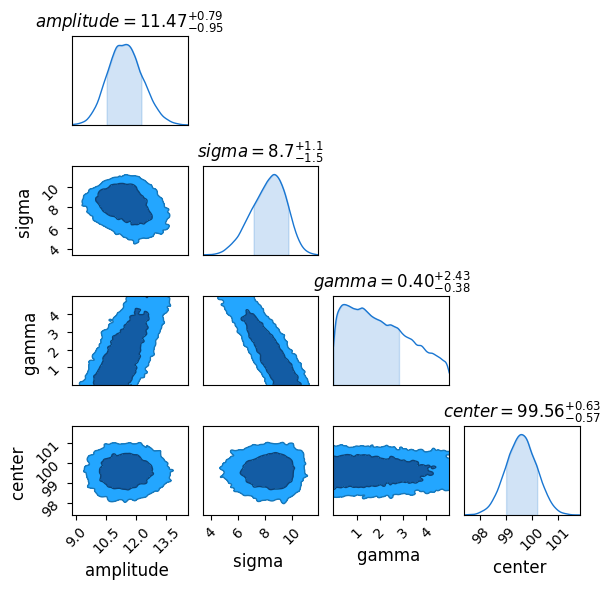

In [13]:
# Extract the results from the sampler.
# The maximum likelihood values should match those of the gas layer we generated above.
c = ChainConsumer()
c.add_chain(np.asarray(flat_sample), parameters=pars)
c.plotter.plot()
# By default chainconsumer reports the 1 sigma intervals 
# above and below the maximum likelihood value.
plt.tight_layout()

Fit the higher frequency line using MCMC but fixing its centroid to that of the lower frequency line.

In [14]:
# Gamma may have a negative value, which is not physical, but 
# the Voigt profile does not care if the value is negative.
pos = abs(sol_180.x) + 1e-2 * np.random.randn(32, len(sol_180.x))
nwalkers, ndim = pos.shape

# Set up and start the MCMC.
kwargs = {"v_cen": soln.x[-1]}
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(velo, spec_180, 1.e-2), kwargs=kwargs
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|                                                                                                                                                                                  | 0/5000 [00:00<?, ?it/s]/home/sandboxes/psalas/RRLpy/py3.9-venv/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.23it/s]


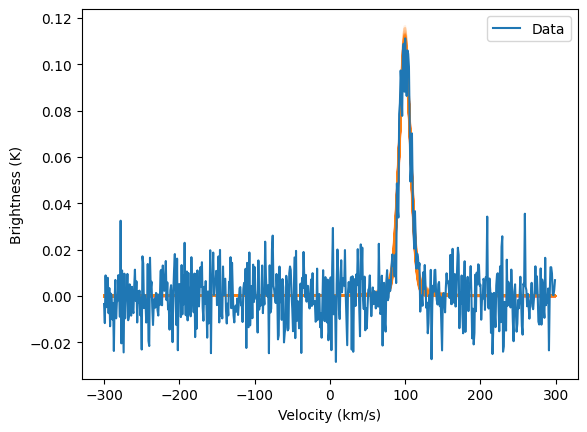

In [17]:
flat_sample = sampler.get_chain(discard=100, thin=15, flat=True)
inds = np.random.randint(len(flat_sample), size=500)
for ind in inds:
    sample = flat_sample[ind]
    plt.plot(velo, model(sample, velo, soln.x[-1]), "C1", alpha=0.1)
plt.plot(velo, spec_180, label="Data")
plt.legend()
plt.xlabel("Velocity (km/s)")
plt.ylabel("Brightness (K)");

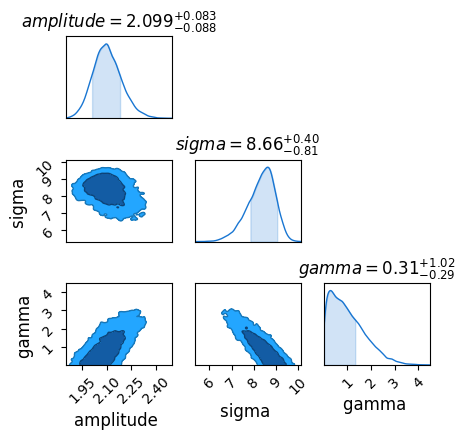

In [16]:
# Extract the results from the sampler.
# The maximum likelihood values should match those of the gas layer we generated above.
c = ChainConsumer()
c.add_chain(np.asarray(flat_sample), parameters=pars[:-1])
c.plotter.plot()
# By default chainconsumer reports the 1 sigma intervals 
# above and below the maximum likelihood value.
plt.tight_layout()